## NFL RF and LGMB Models w/ Standardization and FE - CRSP metric
In this iteration of the models, we standardization all the NextGen data and do some Feature Engineering. In this model, we frame the model from the perspective of the rusher. It can be summary as 3 main components in relation to the rusher:
  
1) Rusher - Including all details of the rusher  
2) Defense - Primarily focused on the defensive line and line backers that are responsible for stopping the rusher.  
3) Offense - Focused on offense line (OL) that is responsible in blocking all defensors.   
   
**Metric Report:**  
Random Forest Train-Test Split: 0.01289     
Random Forest 3 K-Folds Cross Validation: 0.01324     
LGMB Train-Test Split: 0.01314   
LGMB 3 K-Folds Cross Validation: 0.1332 

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 200
# pd.options.display.max_rows = 100

import matplotlib.pyplot as plt
import seaborn as sns

import math
import datetime
from tqdm import tqdm, tqdm_notebook
import gc

# from kaggle.competitions import nflrush

from NFL_utilsV3 import cleaner,player_features,rusher_features,dropper, create_dataframe, crps

import category_encoders as ce

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = '/Users/patman/Documents/Kaggle/nfl-big-data-bowl-2020/'
df_train = pd.read_csv('train.csv',low_memory = False,dtype={'WindSpeed':'object'})

## Preprocessing Data

In [3]:
%%time
df_rusher= create_dataframe(df_train)

Preprocessed
Drop Cols
Wall time: 20.1 s


In [4]:
df_rusher.head()

,S,A,Dis,Quarter,GameClock,PossessionTeam,Down,Distance,NflIdRusher,OffenseFormation,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,Position,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,YardLine_grid,X_std,Y_std,Orientation_std,Dir_std,S_dx,S_dy,A_dx,A_dy,Force,DefenseTeam,OffScoreDiff,TimeElapsed,TimeDelta,PlayerAge,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,OL_diff,OL_TE_diff,run_def,back_from_scrimmage,back_from_1st,back_oriented_downfield,back_dir_downfield,def_X_min,def_X_max,def_X_avg,def_X_std,def_Y_min,def_Y_max,def_Y_avg,def_Y_std,def_DistToRusher_min,def_DistToRusher_max,def_DistToRusher_avg,def_DistToRusher_std,def_TimeToRusher_min,def_TimeToRusher_max,def_TimeToRusher_avg,def_TimeToRusher_std,def_X_min_3,def_X_max_3,def_X_avg_3,def_X_std_3,def_Y_min_3,def_Y_max_3,def_Y_avg_3,def_Y_std_3,def_S_min_3,def_S_max_3,def_S_avg_3,def_S_std_3,def_A_min_3,def_A_max_3,def_A_avg_3,def_A_std_3,def_DistToRusher_min_3,def_DistToRusher_max_3,def_DistToRusher_avg_3,def_DistToRusher_std_3,def_TimeToRusher_min_3,def_TimeToRusher_max_3,def_TimeToRusher_avg_3,def_TimeToRusher_std_3,Def_past_scrimmage_yds,Def_past_scrimmage_count,off_X_min,off_X_max,off_X_avg,off_X_std,off_Y_min,off_Y_max,off_Y_avg,off_Y_std,off_DistToRusher_min,off_DistToRusher_max,off_DistToRusher_avg,off_DistToRusher_std,Def_Spread_X,Off_Spread_X,Def_Spread_Y,Off_Spread_Y,off_X_min_3,off_X_max_3,off_X_avg_3,off_X_std_3,off_Y_min_3,off_Y_max_3,off_Y_avg_3,off_Y_std_3,off_S_min_3,off_S_max_3,off_S_avg_3,off_S_std_3,off_A_min_3,off_A_max_3,off_A_avg_3,off_A_std_3,off_DistToRusher_min_3,off_DistToRusher_max_3,off_DistToRusher_avg_3,off_DistToRusher_std_3
0,3.63,3.35,0.38,1,854.0,NE,3,2,2543773,SHOTGUN,6.0,8,70,205,RB,1,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,63.0,77.0,8.0,south_west,45,41.25,22.803333,18.02,24.26,3.309436,1.491487,3.054163,1.376441,686.75,KC,0.0,0.766667,1.0,25.596251,2,3,6,1,1,3,1,5,3,4,0,3.75,5.75,0,0,44.94,63.37,48.179091,5.294079,14.503333,36.693333,24.442424,7.014714,4.593310,22.415872,9.752491,5.327299,2.176268,86.214891,15.449148,23.941258,45.33,46.00,45.726667,0.351615,20.133333,24.433333,21.753333,2.337777,0.42,1.22,0.786667,0.404145,0.59,1.35,0.890000,0.404475,4.593310,5.448982,4.974183,0.435500,4.466378,10.936453,7.393655,3.278661,0.06,1.0,40.24,45.42,44.338,1.590058,16.423333,35.773333,24.997333,6.132837,1.449724,13.296834,6.170034,3.712747,18.43,5.18,22.19,19.35,44.57,45.42,45.130000,0.485077,20.923333,24.213333,22.196667,1.766475,1.00,1.86,1.453333,0.431895,0.69,1.51,1.186667,0.436616,3.815337,4.401931,4.193776,0.328284
1,3.06,2.41,0.34,1,832.0,NE,1,10,2543773,SHOTGUN,6.0,3,70,205,RB,1,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,63.0,77.0,8.0,south_west,53,48.93,26.173333,329.30,317.80,2.266862,-2.055465,1.785339,-1.618847,494.05,KC,0.0,1.133333,1.0,25.596252,2,3,6,1,1,3,1,5,3,4,0,4.07,14.07,0,0,53.20,71.95,56.561818,5.406292,19.453333,43.903333,28.440606,7.190716,4.287773,23.025872,10.297028,5.833217,3.573144,21.519507,6.949750,5.196440,53.20,53.96,53.520000,0.393954,23.243333,29.063333,26.030000,2.917830,1.18,1.20,1.193333,0.011547,0.55,1.63,1.080000,0.540278,4.287773,5.821151,5.143933,0.782194,3.573144,4.850959,4.311672,0.661797,0.00,0.0,48.21,53.81,52.161,1.842851,21.733333,43.833333,28.810333,7.259279,0.792023,18.102928,6.763977,4.958232,18.75,5.60,24.45,22.10,52.09,52.66,52.450000,0.313209,24.853333,27.793333,26.053333,1.542595,0.48,2.62,1.420000,1.093435,0.76,1.70,1.176667,0.478992,3.424617,4.011646,3.741401,0.296269
2,5.77,2.42,0.60,1,782.0,NE,1,10,2543773,SINGLEBACK,7.0,5,70,205,RB,1,Gillette Stadium,"Foxborough, MA",outdoor,fieldturf,clear,63.0,77.0,8.0,south_west,75,71.34,34.223333,39.18,48.04,3.857889,4.290640,1.618040,1.799541,496.10,KC,0.0,1.966667,2.0,25.596253,2,3,6,1,1,3,1,5,3,4,0,3.66,13.66,0,0,75.25,91.76,78.389091,4.720893,20.443333,44.253333,30.730606,6.577620,4.221670,20.726285,9.903689,5.073290,1.716126,8.937575,3.323861

In [5]:
encoder ='TE'
cat_features = []
dense_features = []
for col in df_rusher.columns:
    if df_rusher[col].dtype =='object':
        cat_features.append(col)
#         print("*cat*", col, len(df_rusher[col].unique()))
    else:
        dense_features.append(col)
#         print("!dense!", col, len(df_rusher[col].unique()))
dense_features.remove("Yards")
#### Cat
train_cat = df_rusher[cat_features]
categories = []
most_appear_each_categories = {}
for col in tqdm(train_cat.columns):
    train_cat.loc[:,col] = train_cat[col].fillna("nan")
    train_cat.loc[:,col] = col + "__" + train_cat[col].astype(str)
    most_appear_each_categories[col] = list(train_cat[col].value_counts().index)[0]
    categories.append(train_cat[col].unique())
categories = np.hstack(categories)

# print(len(categories))

OH=OneHotEncoder(sparse=False)
le = LabelEncoder()
TE = ce.TargetEncoder()
if encoder =='le':
    le.fit(categories)
    for col in tqdm(train_cat.columns):
        train_cat.loc[:, col] = le.transform(train_cat[col])
        num_classes = len(le.classes_)
elif encoder == 'OH':
    OH.fit(train_cat)
    train_cat = pd.DataFrame(OH.transform(train_cat),columns=categories)
elif encoder == "TE":
    TE.fit(train_cat,df_rusher['Yards'])
    train_cat = pd.DataFrame(TE.transform(train_cat),columns=cat_features)
#### Dense
train_dense = df_rusher[dense_features]
sss = {}
medians = {}
for col in tqdm(train_dense.columns):
#         print(col)
    medians[col] = np.nanmedian(train_dense[col])
    train_dense.loc[:, col] = train_dense[col].fillna(medians[col])
#     ss = StandardScaler()
#     train_dense.loc[:, col] = ss.fit_transform(train_dense[col].values[:,None])
#     sss[col] = ss
###
df_final = train_dense.merge(train_cat, how='outer', left_index=True, right_index=True)

100%|██████████| 122/122 [00:06<00:00, 19.51it/s]


In [6]:
cat_features

['PossessionTeam',
 'OffenseFormation',
 'Position',
 'Stadium',
 'Location',
 'StadiumType',
 'Turf',
 'GameWeather',
 'WindDirection',
 'DefenseTeam']

In [7]:
X=df_final
yards = df_rusher['Yards']
y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
features = list(X.columns)

In [8]:
X.head()

,S,A,Dis,Quarter,GameClock,Down,Distance,NflIdRusher,DefendersInTheBox,PlayerHeight,PlayerWeight,Week,Temperature,Humidity,WindSpeed,YardLine_grid,X_std,Y_std,Orientation_std,Dir_std,S_dx,S_dy,A_dx,A_dy,Force,OffScoreDiff,TimeElapsed,TimeDelta,PlayerAge,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,OL_diff,OL_TE_diff,run_def,back_from_scrimmage,back_from_1st,back_oriented_downfield,back_dir_downfield,def_X_min,def_X_max,def_X_avg,def_X_std,def_Y_min,def_Y_max,def_Y_avg,def_Y_std,def_DistToRusher_min,def_DistToRusher_max,def_DistToRusher_avg,def_DistToRusher_std,def_TimeToRusher_min,def_TimeToRusher_max,def_TimeToRusher_avg,def_TimeToRusher_std,def_X_min_3,def_X_max_3,def_X_avg_3,def_X_std_3,def_Y_min_3,def_Y_max_3,def_Y_avg_3,def_Y_std_3,def_S_min_3,def_S_max_3,def_S_avg_3,def_S_std_3,def_A_min_3,def_A_max_3,def_A_avg_3,def_A_std_3,def_DistToRusher_min_3,def_DistToRusher_max_3,def_DistToRusher_avg_3,def_DistToRusher_std_3,def_TimeToRusher_min_3,def_TimeToRusher_max_3,def_TimeToRusher_avg_3,def_TimeToRusher_std_3,Def_past_scrimmage_yds,Def_past_scrimmage_count,off_X_min,off_X_max,off_X_avg,off_X_std,off_Y_min,off_Y_max,off_Y_avg,off_Y_std,off_DistToRusher_min,off_DistToRusher_max,off_DistToRusher_avg,off_DistToRusher_std,Def_Spread_X,Off_Spread_X,Def_Spread_Y,Off_Spread_Y,off_X_min_3,off_X_max_3,off_X_avg_3,off_X_std_3,off_Y_min_3,off_Y_max_3,off_Y_avg_3,off_Y_std_3,off_S_min_3,off_S_max_3,off_S_avg_3,off_S_std_3,off_A_min_3,off_A_max_3,off_A_avg_3,off_A_std_3,off_DistToRusher_min_3,off_DistToRusher_max_3,off_DistToRusher_avg_3,off_DistToRusher_std_3,PossessionTeam,OffenseFormation,Position,Stadium,Location,StadiumType,Turf,GameWeather,WindDirection,DefenseTeam
0,3.63,3.35,0.38,1,854.0,3,2,2543773,6.0,70,205,1,63.0,77.0,8.0,45,41.25,22.803333,18.02,24.26,3.309436,1.491487,3.054163,1.376441,686.75,0.0,0.766667,1.0,25.596251,2,3,6,1,1,3,1,5,3,4,0,3.75,5.75,0,0,44.94,63.37,48.179091,5.294079,14.503333,36.693333,24.442424,7.014714,4.593310,22.415872,9.752491,5.327299,2.176268,86.214891,15.449148,23.941258,45.33,46.00,45.726667,0.351615,20.133333,24.433333,21.753333,2.337777,0.42,1.22,0.786667,0.404145,0.59,1.35,0.890000,0.404475,4.593310,5.448982,4.974183,0.435500,4.466378,10.936453,7.393655,3.278661,0.06,1.0,40.24,45.42,44.338,1.590058,16.423333,35.773333,24.997333,6.132837,1.449724,13.296834,6.170034,3.712747,18.43,5.18,22.19,19.35,44.57,45.42,45.130000,0.485077,20.923333,24.213333,22.196667,1.766475,1.00,1.86,1.453333,0.431895,0.69,1.51,1.186667,0.436616,3.815337,4.401931,4.193776,0.328284,4.489412,4.508161,4.176767,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.561198
1,3.06,2.41,0.34,1,832.0,1,10,2543773,6.0,70,205,1,63.0,77.0,8.0,53,48.93,26.173333,329.30,317.80,2.266862,-2.055465,1.785339,-1.618847,494.05,0.0,1.133333,1.0,25.596252,2,3,6,1,1,3,1,5,3,4,0,4.07,14.07,0,0,53.20,71.95,56.561818,5.406292,19.453333,43.903333,28.440606,7.190716,4.287773,23.025872,10.297028,5.833217,3.573144,21.519507,6.949750,5.196440,53.20,53.96,53.520000,0.393954,23.243333,29.063333,26.030000,2.917830,1.18,1.20,1.193333,0.011547,0.55,1.63,1.080000,0.540278,4.287773,5.821151,5.143933,0.782194,3.573144,4.850959,4.311672,0.661797,0.00,0.0,48.21,53.81,52.161,1.842851,21.733333,43.833333,28.810333,7.259279,0.792023,18.102928,6.763977,4.958232,18.75,5.60,24.45,22.10,52.09,52.66,52.450000,0.313209,24.853333,27.793333,26.053333,1.542595,0.48,2.62,1.420000,1.093435,0.76,1.70,1.176667,0.478992,3.424617,4.011646,3.741401,0.296269,4.489412,4.508161,4.176767,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.561198
2,5.77,2.42,0.60,1,782.0,1,10,2543773,7.0,70,205,1,63.0,77.0,8.0,75,71.34,34.223333,39.18,48.04,3.857889,4.290640,1.618040,1.799541,496.10,0.0,1.966667,2.0,25.596253,2,3,6,1,1,3,1,5,3,4,0,3.66,13.66,0,0,75.25,91.76,78.389091,4.720893,20.443333,44.253333,30.730606,6.577620,4.221670,20.726285,9.903689,5.073290,1.716126,8.937575,3.323861,2.236796,75.35,75.62,75.446667,0.150444,29.913333,37.153333,33.323333,3.638228,2.46,3.22,2.7

In [9]:
# corr = X.corr()

In [10]:
# sns.set(rc={'figure.figsize':(30, 30)})
# plt.figure() 
# ax = sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", fmt='.1g')
# plt.savefig('corr_heatmap.png')
# plt.show()

In [11]:
# # Drop highly correlated features (37->28)
# columns = np.full((corr.shape[0],), True, dtype=bool)
# for i in range(corr.shape[0]):
#     for j in range(i+1, corr.shape[0]):
#         if corr.iloc[i,j] >= 0.99:
#             if columns[j]:
#                 columns[j] = False

# feature_columns = X.columns[columns].values
# drop_columns = X.columns[columns == False].values
# print(feature_columns)
# print(len(feature_columns))
# print(drop_columns)
# print(len(drop_columns))

## Random Forest Model

### Train-Test Split RF Model

In [12]:
%%time
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=15, min_samples_split=7, n_estimators=50, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
AE_,score1_ = crps(y_test,y_pred)

Wall time: 20.6 s


In [13]:
print('CRPS: ',score1_)
print('MAE:',AE_.mean())

CRPS:  0.012889608132935734
MAE: 2.565032018454211


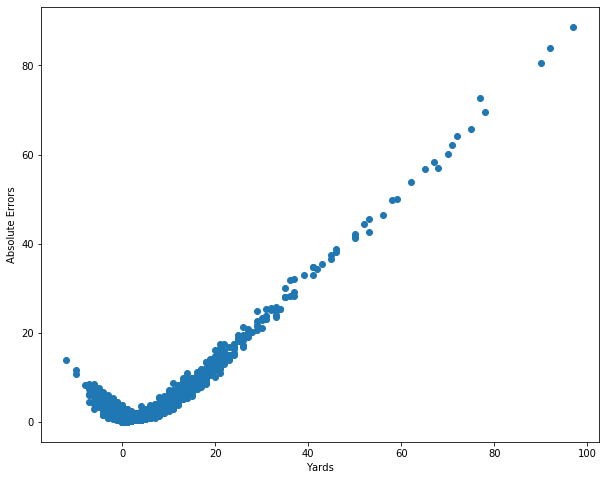

In [14]:
yards_test=[]
for i in range(len(y_test)):
    index =np.argmax(y_test[i])
    yard =index-99
    yards_test.append(yard)
    
yards_test=np.asarray(yards_test)
    
plt.figure(figsize = (10,8))
plt.scatter(yards_test, AE_)
# plt.plot(y_test, y_test, color='orange')
plt.xlabel("Yards")
plt.ylabel("Absolute Errors")
plt.show()

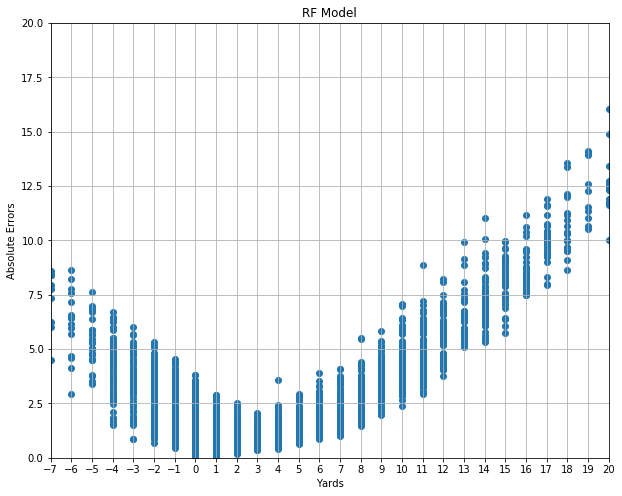

In [15]:
plt.figure(figsize = (10,8))
plt.scatter(yards_test, AE_)
plt.title('RF Model')
plt.xlabel("Yards")
plt.ylabel("Absolute Errors")
plt.xticks(np.arange(min(yards_test), max(yards_test)+1, 1.0))
plt.xlim((-7,20))
plt.ylim((0,20))
plt.grid()
# plt.savefig(f'RF_AE.png')
plt.show()

In [16]:
feature_import_RF =model.feature_importances_
features_RF = X.columns.T
RF_feat_df = pd.DataFrame({'Features': features_RF,
                        'Importances': feature_import_RF})

In [17]:
RF_feat_df.sort_values('Importances',ascending=False).head(20)

,Features,Importances
22,A_dx,0.031332
1,A,0.026450
20,S_dx,0.024955
24,Force,0.022980
40,back_from_scrimmage,0.019003
56,def_TimeToRusher_min,0.017125
0,S,0.017069
80,def_TimeToRusher_min_3,0.013321
15,YardLine_grid,0.013271
84,Def_past_scrimmage_yds,0.012492


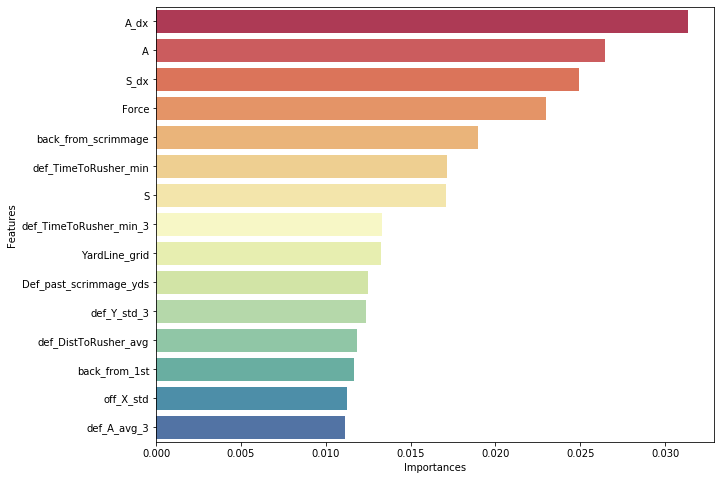

In [18]:
plt.figure(figsize=(10,8))
sns.barplot(x='Importances',y='Features',data=RF_feat_df.sort_values(by='Importances',ascending=False).head(15),palette='Spectral')
# plt.savefig(f'RF_FeatureImportances.png',bbox_inches="tight")

In [19]:
#Feature Selection Methods
# fs_ = SelectFromModel(model, prefit=True)
# X.shape
# fs_.transform(X).shape

# feature_idx = fs_.get_support()
# feature_name = X.columns[feature_idx]
# print(feature_name)

### Cross-Validation RF Model (3 K-Folds)

In [20]:
X=df_final
yards = df_rusher['Yards']
y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
features = list(X.columns)

In [21]:
kf = KFold(n_splits=3, random_state=42)
scores_RF = []
MAE_RF = []
models_RF=[]
for i, (tdx, vdx) in tqdm(enumerate(kf.split(X, y))):
    print(f'Fold : {i}')
    X_train, X_val, y_train, y_val = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
    model = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=15, min_samples_split=7, n_estimators=50, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    AE_,score_ = crps(y_val, model.predict(X_val))
    print('CRPS: ',score1_)
    print('MAE:',AE_.mean())
    scores_RF.append(score_)
    models_RF.append(model)
    MAE_RF.append(AE_.mean())

0it [00:00, ?it/s]

Fold : 0
CRPS:  0.012889608132935734
MAE: 2.4936265491909952


1it [00:17, 17.90s/it]

Fold : 1
CRPS:  0.012889608132935734
MAE: 2.5031957576572443


2it [00:35, 17.93s/it]

Fold : 2
CRPS:  0.012889608132935734
MAE: 2.921404772856343


3it [00:53, 17.77s/it]


In [22]:
print('Avg CRPS: ',np.mean(scores_RF))
print('Avg MAE: ',np.mean(MAE_RF))

Avg CRPS:  0.01326336194255374
Avg MAE:  2.639409026568194


In [23]:
feature_import_RF_0 =models_RF[0].feature_importances_
feature_import_RF_1 =models_RF[1].feature_importances_
feature_import_RF_2 =models_RF[2].feature_importances_
# feature_import_RF_3 =models_RF[3].feature_importances_
# feature_import_RF_4 =models_RF[4].feature_importances_
features_RF = X.columns.T
RF_feat_df2 = pd.DataFrame({'Features': features_RF,
                        'Importances_0': feature_import_RF_0,
                        'Importances_1': feature_import_RF_1,
                        'Importances_2': feature_import_RF_2})   #'Importances_3': feature_import_RF_3,'Importances_4': feature_import_RF_4
RF_feat_df2['average'] = RF_feat_df2[[f'Importances_{i}' for i in range(3)]].mean(axis=1)
RF_feat_df2.sort_values('average',ascending=False).head(10)

,Features,Importances_0,Importances_1,Importances_2,average
22,A_dx,0.024510,0.032103,0.036214,0.030942
1,A,0.015606,0.025473,0.043990,0.028356
20,S_dx,0.018235,0.024654,0.030154,0.024348
24,Force,0.016974,0.022820,0.028286,0.022693
40,back_from_scrimmage,0.014479,0.018222,0.022432,0.018378
0,S,0.013225,0.017700,0.018160,0.016362
56,def_TimeToRusher_min,0.016266,0.015576,0.012666,0.014836
15,YardLine_grid,0.014666,0.012978,0.016138,0.014594
54,def_DistToRusher_avg,0.016518,0.012035,0.010237,0.012930
84,Def_past_scrimmage_yds,0.013571,0.011443,0.013744,0.012919


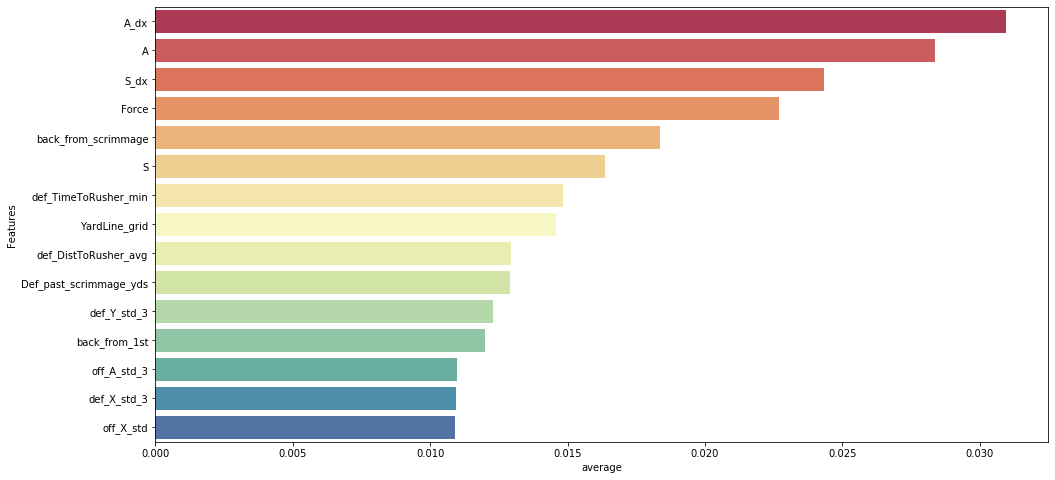

In [24]:
plt.figure(figsize=(16,8))
sns.barplot(x='average',y='Features',data=RF_feat_df2.sort_values(by='average',ascending=False).head(15),palette='Spectral')

In [25]:
# # If we had yards for holdout set
# df_test = create_dataframe(df_holdout)
# #### Cat
# train_cat_test = df_test[cat_features]
# for col in tqdm_notebook(train_cat_test.columns):
#     train_cat_test.loc[:,col] = train_cat_test[col].fillna("nan")
#     train_cat_test.loc[:,col] = col + "__" + train_cat_test[col].astype(str)

# if encoder =='le':
#     for col in tqdm_notebook(train_cat.columns):
#         train_cat_test.loc[:, col] = le.transform(train_cat_test[col])

# elif encoder == 'OH':
#     train_cat_test = pd.DataFrame(OH.transform(train_cat_test),columns=categories)
# elif encoder =='TE':
#     train_cat_test = pd.DataFrame(TE.transform(train_cat_test),columns=cat_features)
# #### Dense
# train_dense_test = df_test[dense_features]
# for col in tqdm_notebook(train_dense_test.columns):
#     train_dense_test.loc[:, col] = train_dense_test[col].fillna(medians[col])
#     train_dense_test.loc[:, col] = sss[col].transform(train_dense_test[col].values[:,None])
# ###
# df_final_test = train_dense_test.merge(train_cat_test, how='outer', left_index=True, right_index=True)

# y_pred2 = model.predict(df_final_test)


## LGB Model

### Train-Test Split LGBM

In [26]:
X=df_final
yards = df_rusher['Yards']
y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
features = list(X.columns)

In [27]:
metric = "multi_logloss"
param = {'num_leaves': 50, #Original 50
         'min_data_in_leaf': 30, #Original 30
         'objective':'multiclass',
         'num_class': 199, # 199 possible places
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7, #0.9
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": metric,
         "lambda_l1": 0.1,
         "verbosity": -1,
         "seed":1234}

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_valid=y_test
y_train=np.argmax(y_train,axis=1)
y_test=np.argmax(y_test,axis=1)
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test)
num_round = 10000
model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
AE_,score_ = crps(y_valid, model.predict(X_test, num_iteration=model.best_iteration))
print('CRPS: ',score1_)
print('MAE:',AE_.mean())


Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 2.10066	valid_1's multi_logloss: 2.82263
[200]	training's multi_logloss: 1.74504	valid_1's multi_logloss: 2.7944
[300]	training's multi_logloss: 1.49694	valid_1's multi_logloss: 2.7881
[400]	training's multi_logloss: 1.30747	valid_1's multi_logloss: 2.79529
Early stopping, best iteration is:
[295]	training's multi_logloss: 1.50776	valid_1's multi_logloss: 2.78802
CRPS:  0.012889608132935734
MAE: 2.6191443089069857


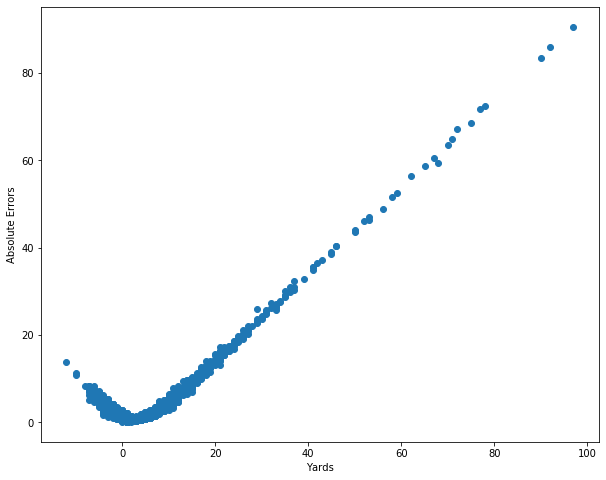

In [28]:
yards_test=[]
for i in range(len(y_valid)):
    index =np.argmax(y_valid[i])
    yard =index-99
    yards_test.append(yard)
    
plt.figure(figsize = (10,8))
plt.scatter(yards_test, AE_)
# plt.plot(y_test, y_test, color='orange')
plt.xlabel("Yards")
plt.ylabel("Absolute Errors")
plt.show()

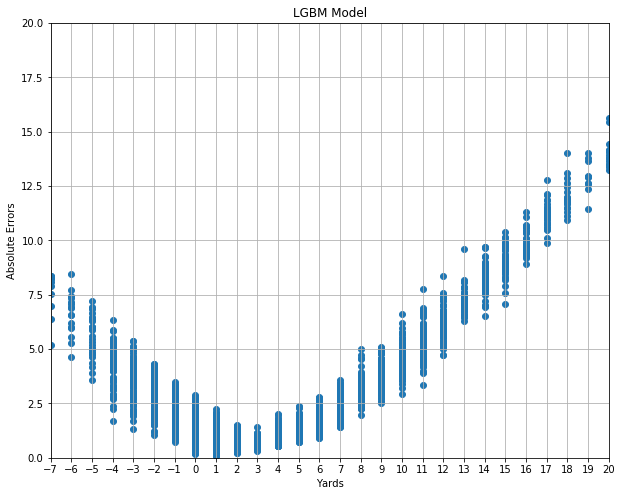

In [29]:
plt.figure(figsize = (10,8))
plt.scatter(yards_test, AE_)
plt.title('LGBM Model')
plt.xlabel("Yards")
plt.ylabel("Absolute Errors")
plt.xticks(np.arange(min(yards_test), max(yards_test)+1, 1.0))
plt.xlim((-7,20))
plt.ylim((0,20))
plt.grid()
# plt.savefig(f'LGBM_AE.png')
plt.show()

In [30]:
feature_importance_df=pd.DataFrame()
feature_importance_df["feature"] = X.columns
feature_importance_df[f"importance_split"] = model.feature_importance(importance_type='split')
feature_importance_df[f'importance_gain'] =  model.feature_importance(importance_type='gain')

In [31]:
feature_importance_df.sort_values('importance_gain',ascending=False).head(10)

,feature,importance_split,importance_gain
22,A_dx,8536,70406.979623
20,S_dx,9265,62014.537094
1,A,7754,46771.907708
40,back_from_scrimmage,7865,41405.589548
24,Force,7096,41385.688116
0,S,7356,39730.226328
56,def_TimeToRusher_min,6533,36283.886719
84,Def_past_scrimmage_yds,7071,34536.954119
67,def_Y_std_3,8248,33804.469913
98,Def_Spread_X,6783,31340.332650


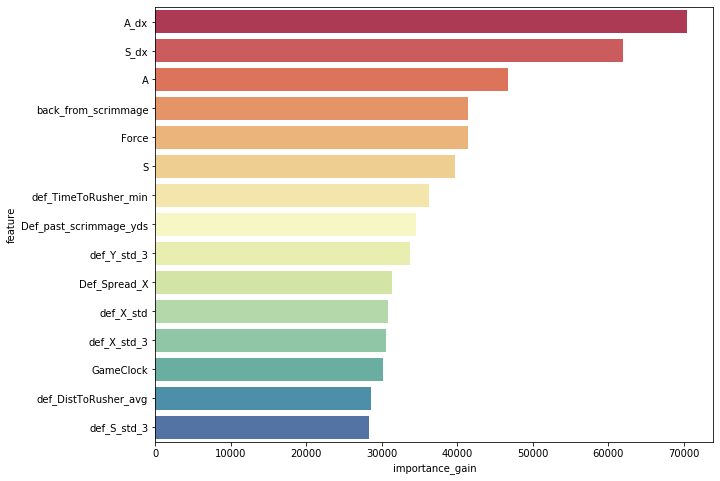

In [32]:
plt.figure(figsize=(10,8))
sns.barplot(x='importance_gain',y='feature',data=feature_importance_df.sort_values(by='importance_gain',ascending=False).head(15),palette='Spectral')
# plt.savefig(f'LGBM_FeatureImportances.png',bbox_inches="tight")

In [33]:
# lgb.plot_importance(model, importance_type='split',max_num_features=40,figsize=(15,8))

In [34]:
# lgb.plot_importance(model, importance_type='gain',max_num_features=40,figsize=(15,8))

### Cross-Validation LGBM (3 K-Folds)

In [35]:
X=df_final
yards = df_rusher['Yards']
y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
features = list(X.columns)

In [36]:
X.head()

,S,A,Dis,Quarter,GameClock,Down,Distance,NflIdRusher,DefendersInTheBox,PlayerHeight,PlayerWeight,Week,Temperature,Humidity,WindSpeed,YardLine_grid,X_std,Y_std,Orientation_std,Dir_std,S_dx,S_dy,A_dx,A_dy,Force,OffScoreDiff,TimeElapsed,TimeDelta,PlayerAge,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,OL_diff,OL_TE_diff,run_def,back_from_scrimmage,back_from_1st,back_oriented_downfield,back_dir_downfield,def_X_min,def_X_max,def_X_avg,def_X_std,def_Y_min,def_Y_max,def_Y_avg,def_Y_std,def_DistToRusher_min,def_DistToRusher_max,def_DistToRusher_avg,def_DistToRusher_std,def_TimeToRusher_min,def_TimeToRusher_max,def_TimeToRusher_avg,def_TimeToRusher_std,def_X_min_3,def_X_max_3,def_X_avg_3,def_X_std_3,def_Y_min_3,def_Y_max_3,def_Y_avg_3,def_Y_std_3,def_S_min_3,def_S_max_3,def_S_avg_3,def_S_std_3,def_A_min_3,def_A_max_3,def_A_avg_3,def_A_std_3,def_DistToRusher_min_3,def_DistToRusher_max_3,def_DistToRusher_avg_3,def_DistToRusher_std_3,def_TimeToRusher_min_3,def_TimeToRusher_max_3,def_TimeToRusher_avg_3,def_TimeToRusher_std_3,Def_past_scrimmage_yds,Def_past_scrimmage_count,off_X_min,off_X_max,off_X_avg,off_X_std,off_Y_min,off_Y_max,off_Y_avg,off_Y_std,off_DistToRusher_min,off_DistToRusher_max,off_DistToRusher_avg,off_DistToRusher_std,Def_Spread_X,Off_Spread_X,Def_Spread_Y,Off_Spread_Y,off_X_min_3,off_X_max_3,off_X_avg_3,off_X_std_3,off_Y_min_3,off_Y_max_3,off_Y_avg_3,off_Y_std_3,off_S_min_3,off_S_max_3,off_S_avg_3,off_S_std_3,off_A_min_3,off_A_max_3,off_A_avg_3,off_A_std_3,off_DistToRusher_min_3,off_DistToRusher_max_3,off_DistToRusher_avg_3,off_DistToRusher_std_3,PossessionTeam,OffenseFormation,Position,Stadium,Location,StadiumType,Turf,GameWeather,WindDirection,DefenseTeam
0,3.63,3.35,0.38,1,854.0,3,2,2543773,6.0,70,205,1,63.0,77.0,8.0,45,41.25,22.803333,18.02,24.26,3.309436,1.491487,3.054163,1.376441,686.75,0.0,0.766667,1.0,25.596251,2,3,6,1,1,3,1,5,3,4,0,3.75,5.75,0,0,44.94,63.37,48.179091,5.294079,14.503333,36.693333,24.442424,7.014714,4.593310,22.415872,9.752491,5.327299,2.176268,86.214891,15.449148,23.941258,45.33,46.00,45.726667,0.351615,20.133333,24.433333,21.753333,2.337777,0.42,1.22,0.786667,0.404145,0.59,1.35,0.890000,0.404475,4.593310,5.448982,4.974183,0.435500,4.466378,10.936453,7.393655,3.278661,0.06,1.0,40.24,45.42,44.338,1.590058,16.423333,35.773333,24.997333,6.132837,1.449724,13.296834,6.170034,3.712747,18.43,5.18,22.19,19.35,44.57,45.42,45.130000,0.485077,20.923333,24.213333,22.196667,1.766475,1.00,1.86,1.453333,0.431895,0.69,1.51,1.186667,0.436616,3.815337,4.401931,4.193776,0.328284,4.489412,4.508161,4.176767,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.561198
1,3.06,2.41,0.34,1,832.0,1,10,2543773,6.0,70,205,1,63.0,77.0,8.0,53,48.93,26.173333,329.30,317.80,2.266862,-2.055465,1.785339,-1.618847,494.05,0.0,1.133333,1.0,25.596252,2,3,6,1,1,3,1,5,3,4,0,4.07,14.07,0,0,53.20,71.95,56.561818,5.406292,19.453333,43.903333,28.440606,7.190716,4.287773,23.025872,10.297028,5.833217,3.573144,21.519507,6.949750,5.196440,53.20,53.96,53.520000,0.393954,23.243333,29.063333,26.030000,2.917830,1.18,1.20,1.193333,0.011547,0.55,1.63,1.080000,0.540278,4.287773,5.821151,5.143933,0.782194,3.573144,4.850959,4.311672,0.661797,0.00,0.0,48.21,53.81,52.161,1.842851,21.733333,43.833333,28.810333,7.259279,0.792023,18.102928,6.763977,4.958232,18.75,5.60,24.45,22.10,52.09,52.66,52.450000,0.313209,24.853333,27.793333,26.053333,1.542595,0.48,2.62,1.420000,1.093435,0.76,1.70,1.176667,0.478992,3.424617,4.011646,3.741401,0.296269,4.489412,4.508161,4.176767,4.665816,4.706647,4.256599,4.268733,4.274059,4.309946,4.561198
2,5.77,2.42,0.60,1,782.0,1,10,2543773,7.0,70,205,1,63.0,77.0,8.0,75,71.34,34.223333,39.18,48.04,3.857889,4.290640,1.618040,1.799541,496.10,0.0,1.966667,2.0,25.596253,2,3,6,1,1,3,1,5,3,4,0,3.66,13.66,0,0,75.25,91.76,78.389091,4.720893,20.443333,44.253333,30.730606,6.577620,4.221670,20.726285,9.903689,5.073290,1.716126,8.937575,3.323861,2.236796,75.35,75.62,75.446667,0.150444,29.913333,37.153333,33.323333,3.638228,2.46,3.22,2.7

In [37]:
metric = "multi_logloss"
param = {'num_leaves': 50, #Original 50
         'min_data_in_leaf': 30, #Original 30
         'objective':'multiclass',
         'num_class': 199, # 199 possible places
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7, #0.9
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": metric,
         "lambda_l1": 0.1,
         "verbosity": -1,
         "seed":1234}

models = []
kf = KFold(n_splits=3, random_state=42)
score = []
MAE = []
feature_importance_df2 = pd.DataFrame()
X_columns=X.columns.values.tolist()
best_validation_scores = []
# y = np.argmax(y, axis=1)

for i, (tdx, vdx) in tqdm(enumerate(kf.split(X, y))):
    print(f'Fold : {i}')
    X_train, X_val, y_train, y_val = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
    y_valid=y_val
    y_train=np.argmax(y_train,axis=1)
    y_val=np.argmax(y_val,axis=1)
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    num_round = 10000
    model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    AE_,score_ = crps(y_valid, model.predict(X_val, num_iteration=model.best_iteration))
#     score_ = crps(np.expand_dims(y_val, axis=1), model.predict(X_val, num_iteration=model.best_iteration))
    print('CRPS: ',score1_)
    print('MAE:',AE_.mean())
#     feature_importance[ i, :] = model.feature_importance()
#     fold_importance_df = pd.DataFrame()
    feature_importance_df2["feature"] = X_columns
    feature_importance_df2[f"importance_{i}"] = model.feature_importance(importance_type='gain')

#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    best_validation_scores.append(model.best_score['valid_1'][metric])
    score.append(score_)
    MAE.append(AE_.mean())
    models.append(model)
print('Avg CRPS: ',np.mean(scores_RF))
print('Avg MAE: ',np.mean(MAE_RF))


0it [00:00, ?it/s]

Fold : 0
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 2.08693	valid_1's multi_logloss: 2.79156
[200]	training's multi_logloss: 1.71468	valid_1's multi_logloss: 2.76159
[300]	training's multi_logloss: 1.45641	valid_1's multi_logloss: 2.75418
[400]	training's multi_logloss: 1.25994	valid_1's multi_logloss: 2.75933
Early stopping, best iteration is:
[299]	training's multi_logloss: 1.4586	valid_1's multi_logloss: 2.75413
CRPS:  0.012889608132935734
MAE: 2.5707829997676455


1it [03:48, 228.32s/it]

Fold : 1
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 2.06897	valid_1's multi_logloss: 2.80463
[200]	training's multi_logloss: 1.6955	valid_1's multi_logloss: 2.77731
[300]	training's multi_logloss: 1.43834	valid_1's multi_logloss: 2.77255
[400]	training's multi_logloss: 1.24282	valid_1's multi_logloss: 2.78009
Early stopping, best iteration is:
[279]	training's multi_logloss: 1.48595	valid_1's multi_logloss: 2.77196
CRPS:  0.012889608132935734
MAE: 2.5529394117309003


2it [05:43, 194.45s/it]

Fold : 2
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 2.04135	valid_1's multi_logloss: 2.89752
[200]	training's multi_logloss: 1.67062	valid_1's multi_logloss: 2.89529
[300]	training's multi_logloss: 1.41469	valid_1's multi_logloss: 2.90708
Early stopping, best iteration is:
[170]	training's multi_logloss: 1.76569	valid_1's multi_logloss: 2.89406
CRPS:  0.012889608132935734
MAE: 2.8476121434893895


3it [06:57, 158.30s/it]


Avg CRPS:  0.01326336194255374
Avg MAE:  2.639409026568194


In [38]:
feature_importance_df2['average'] = feature_importance_df2[[f'importance_{i}' for i in range(3)]].mean(axis=1)
feature_importance_df2.sort_values('average',ascending=False).head(20)

,feature,importance_0,importance_1,importance_2,average
22,A_dx,51466.606787,64926.384145,62870.653917,59754.548283
20,S_dx,41583.776395,55492.548051,59716.169278,52264.164575
1,A,32114.728455,40996.712225,59828.265554,44313.235411
24,Force,28160.585461,36272.305321,40703.303257,35045.398013
40,back_from_scrimmage,34615.067898,36644.671489,28345.988412,33201.909267
0,S,28988.976451,34063.303099,27322.476454,30124.918668
84,Def_past_scrimmage_yds,31686.421516,30140.164561,25562.354835,29129.646971
67,def_Y_std_3,30885.877874,32353.197131,22028.482624,28422.519210
56,def_TimeToRusher_min,31308.455530,28932.415275,21975.241468,27405.370758
63,def_X_std_3,29752.981367,27591.568789,20097.845417,25814.131858


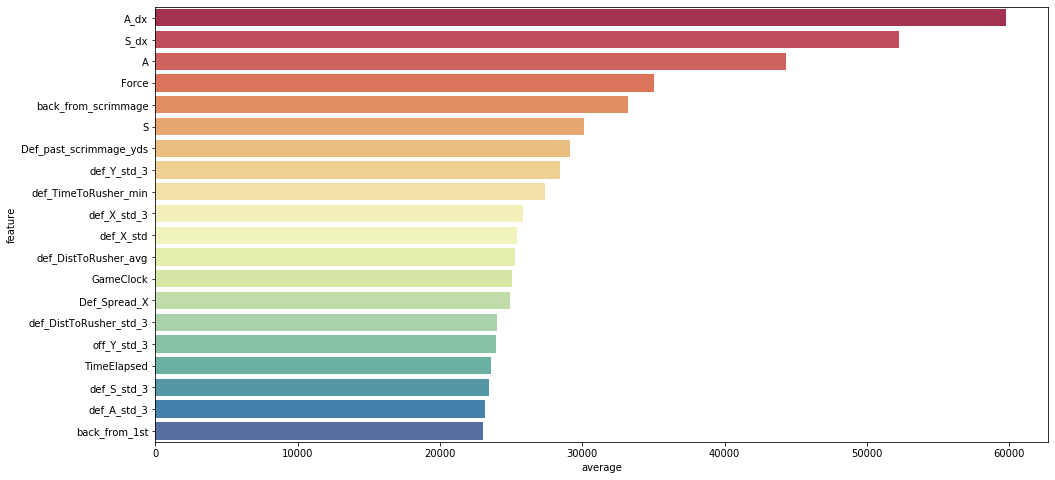

In [39]:
plt.figure(figsize=(16,8))
sns.barplot(x='average',y='feature',data=feature_importance_df2.sort_values(by='average',ascending=False).head(20),palette='Spectral')